# Goodness of fit test for the density of the invariant measure of a Markov chain

We test our method on three examples:
- an AR(1) process
- a Markov chain with prescribed invariant measure built with an independent Metropolis Hastings algorithm
- an ARCH process

We consider tests of level $\alpha$ (typically equal to $5\%$). We compare the power of our test with the ones of the Kolmogorov-Smirnov test and the $\chi^2$ test.



In [1]:
import numpy as np
import scipy as sc
from scipy import stats
import math
import matplotlib.pyplot as plt
from scipy.integrate import quad

In [13]:
def gaussian(x,mu,sigma):
    return (2*np.pi*sigma**2)**(-1/2) * np.exp(-(x-mu)**2/(2 * sigma**2))

def chi2_power(SAMPLES, SAMPLES_true, fexpected, alpha):
    K = SAMPLES.shape[1]
    #quantile = stats.chi2.ppf(1-alpha, df=K-1)
    chi2list = []
    for i in range(SAMPLES_true.shape[0]):
        chi2list.append(stats.chisquare(f_obs=SAMPLES_true[i,:], f_exp=fexpected)[0])
    chi2list = np.sort(chi2list)
    quantile = chi2list[int(len(chi2list)*(1-alpha))]
    power = 0
    for i in range(SAMPLES.shape[0]):
        if quantile < stats.chisquare(f_obs=SAMPLES[i,:], f_exp=fexpected)[0]:
            power += 1
    power /= SAMPLES.shape[0]
    return power

def chi2_test(CHAINS, CHAINS_true, true_density, alpha, xmin, xmax, K=40):
    interval = np.linspace(xmin,xmax,K)
    fexpected = np.zeros(K)
    step = (xmax-xmin)/K
    for k in range(K):
        fexpected[k] = quad(true_density,xmin+k*step,xmin+(k+1)*step)[0]
    fexpected /= np.sum(fexpected)
    SAMPLES = np.zeros((CHAINS.shape[0],K))
    SAMPLES_true = np.zeros((CHAINS_true.shape[0],K))
    for i in range(CHAINS.shape[0]):
        for j in range(CHAINS.shape[1]):
            k = np.floor((CHAINS[i,j]-xmin)/step) 
            if k<0:
                SAMPLES[i,0] += 1
            elif k>=K:
                SAMPLES[i,-1] += 1
            else:
                SAMPLES[i,int(k)] += 1
    for i in range(CHAINS_true.shape[0]):  
        for j in range(CHAINS_true.shape[1]): 
            k = np.floor((CHAINS_true[i,j]-xmin)/step)
            if k<0:  
                SAMPLES_true[i,0] += 1
            elif k>=K:
                SAMPLES_true[i,-1] += 1
            else:
                SAMPLES_true[i,int(k)] += 1
    SAMPLES /= SAMPLES.shape[1]
    SAMPLES_true /= SAMPLES_true.shape[1]
    return chi2_power(SAMPLES, SAMPLES_true, fexpected, alpha) 

In [3]:
def KS_test(SAMPLES, SAMPLES_true, true_density, alpha, mode='norm', params=(0,1)):
    K = SAMPLES.shape[1]
    #quantile = stats.chi2.ppf(1-alpha, df=K-1)
    kslist = []
    for i in range(SAMPLES_true.shape[0]):
        kslist.append(stats.kstest(SAMPLES_true[i,:], mode, args=params)[0])
    kslist = np.sort(kslist)
    quantile = kslist[int(len(kslist)*(1-alpha))]
    power = 0
    for i in range(SAMPLES.shape[0]):
        if quantile < stats.kstest(SAMPLES[i,:], mode, args=params)[0]:
            power += 1
    power /= SAMPLES.shape[0]
    return power

In [4]:
def normL2(density, xmin, xmax):
    def fint(a):
        return (density(a)**2)
    return (np.sqrt(quad(fint, xmin, xmax)[0]))

def build_chain(ini_state,transition,n,numberchains=1):
    if numberchains==1:
        chain = np.zeros(n)
        state = ini_state
        for i in range(n):
            chain[i] = state
            state = transition(state)
        return chain
    else:
        chains = np.zeros((numberchains,n))
        for j in range(numberchains):
            state = ini_state
            for i in range(n):
                chains[j,i] = state
                state = transition(state)
        return chains

def trigo_basis(a, l):
    if l==0:
        temp = np.ones(len(a))
    elif l%2==0:
        temp = np.sqrt(2) * np.sin(2*np.pi*a*l/2) 
    else:
        temp = np.sqrt(2) * np.cos(2*np.pi*a*(l+1)/2) 
    loc = np.where(a<0)
    temp[loc]=0
    loc = np.where(a>1)
    temp[loc]=0
    return temp

def theta_trigo(chain, l):
    theta = 0
    vec = trigo_basis(chain, l)
    VEC = np.dot(vec.reshape(-1,1),vec.reshape(1,-1))
    theta += np.sum(VEC)-np.sum(np.diag(VEC))
    n = len(chain)            
    theta *= 1/(n*(n-1))
    return theta

def theta_hist(chain, l):
    theta = 0
    vec = np.array(list(map(lambda x:np.floor(x*l),chain)))
    n = len(chain)
    for i in range(n):
        for j in range(n):
            if vec[i] == vec[j] and i!=j:
                theta += np.sqrt(l)
    theta *= 1/(n*(n-1))
    return theta

def compute_hatTm(density, chain, xmin, xmax, list_models):
    hatTm = 0
    n = len(chain)
    hatTms = [0]
    for mode,dmin,dmax in list_models:
        for D in range(dmin,dmax):
            hatTms.append(0)
            if mode=='trigo':
                hatTm = theta_trigo(chain, D)
                hatTms[-1] = hatTm + hatTms[-2]
            else:
                hatTm = theta_hist(chain, D)
                hatTms[-1] = hatTm
    hatTms = hatTms[1:]
    hatTms = np.array(hatTms)
    hatTms += normL2(density, xmin, xmax)**2
    for x in chain:
        hatTms -= (2/n) * density(x)
    return hatTms

def compute_hattm(density, CHAINS, xmin, xmax, grid_u, list_models):
    nbchains = CHAINS.shape[0]
    nbmodels = 0
    for mode,dmin,dmax in list_models:
        nbmodels += dmax-dmin
    quantiles = np.zeros((len(grid_u),nbmodels))
    HAT = np.zeros((nbmodels,nbchains))
    for j in range(nbchains):
        hatTms = compute_hatTm(density, CHAINS[j,:], xmin, xmax, list_models)
        HAT[:,j] = hatTms.reshape(-1)
    for i in range(nbmodels):
        hatTms = np.sort(HAT[i,:])[::-1]
        for k in range(len(grid_u)):
            quantiles[k,i] = hatTms[int(grid_u[k]*len(hatTms))]
    return quantiles

def compute_ualpha(CHAINSproba, CHAINSquantiles, density, xmin, xmax, grid_u, alpha, list_models):
    power = 0
    nbmodels = len(list_models)
    nbchains = CHAINSproba.shape[0]
    u2probas = np.zeros(len(grid_u))
    quantiles = compute_hattm(density, CHAINSquantiles, xmin, xmax, grid_u, list_models)
    for j in range(nbchains):
        count = 0
        hatTms = compute_hatTm(density, CHAINSproba[j,:], xmin, xmax, list_models)
        for k in range(len(grid_u)):
            check = np.max(hatTms > quantiles[k,:])
            if check>0:
                u2probas[k] += 1
    u2probas /= nbchains
    bestindu = 0
    while  u2probas[bestindu+1]-alpha <= 0:
        bestindu += 1
    return grid_u[bestindu], quantiles[bestindu,:]

def compute_power(density, CHAINS, xmin, xmax, list_models, quantiles):
    power = 0
    nbchains = len(CHAINS)
    for j in range(nbchains):
        hatTms = compute_hatTm(density, CHAINS[j,:], xmin, xmax, list_models)
        check = np.max(hatTms > quantiles)
        if check > 0:
            power += 1
    power /= nbchains
    return power

# Example 1: AR(1)

In [5]:
np.random.seed(2)
theta = 0.8
tau = 1
# INVARIANT MEASURE OF THE CHAIN
def H(x):
    return theta*x
def true_chain(prev_state):
        """ Generation of the chain with an AR(1) process """
        z = np.random.normal(0,tau**2)
        return H(prev_state) + z
def true_density(x):
    var = tau**2/(1-theta**2)
    return (np.exp(-x**2/(2*var)) / np.sqrt(2*np.pi*var))

# ALTERNATIVE
mu = 0
sigma = np.sqrt(1.2)
def H1(x):
    return (np.exp(-(x-mu)**2/(2*sigma**2)) / np.sqrt(2*np.pi*sigma**2))
def chain_H1(prev_state):
    return np.random.normal(mu,sigma**2)

# ESTIMATION OF THE QUANTILES
CHAINSproba = build_chain(0,chain_H1,100,numberchains=100)
CHAINSquantiles = build_chain(0,chain_H1,100,numberchains=100)
alpha = 0.05
grid_u = np.linspace(0,2*alpha,100)
list_models = [['hist',1,10]]
xmin = -30
xmax = 30
ualpha, quantiles = compute_ualpha(CHAINSproba, CHAINSquantiles, H1, xmin, xmax, grid_u, alpha, list_models)

#### Power of our test

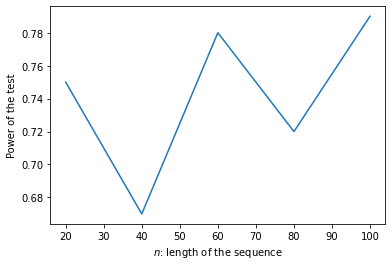

In [10]:
liste_n = [20*i for i in range(1,6)]
powers = []
for n in liste_n:
    CHAINS = build_chain(0,true_chain,n,numberchains=100)
    power = compute_power(H1, CHAINS, xmin, xmax, list_models, quantiles)
    powers.append(power)
plt.plot(liste_n,powers)
plt.ylabel('Power of the test')
plt.xlabel('$n$: length of the sequence')
plt.show()

#### Comparison with the KS test and the $\chi^2$ test

In [11]:
chi2power = chi2_test(CHAINS, CHAINSquantiles, H1, alpha, -5,5, K=100)
KSpower = KS_test(CHAINS, CHAINSquantiles, H1, alpha, mode='norm', params=(mu,sigma))
print('CHI2 POWER',chi2power)
print('KS POWER',KSpower)

CHI2 POWER 0.66
KS POWER 0.69


#### Visualization of the density of the invariant distribution of the chain and of an challenging alternative


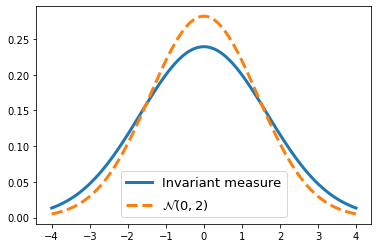

In [14]:
CHAINS = build_chain(0, true_chain, 10000, numberchains=2)
x = np.linspace(-4,4,100)
y = list(map(true_density,x))
mu = 0
sigma = np.sqrt(2)
def H1prop(x):
    return gaussian(x,mu,sigma)
def H1(x):
    return H1prop(x)
yb = list(map(H1,x))
plt.plot(x,y, label='Invariant measure', linewidth=3)
plt.plot(x,yb,label='$\mathcal{N}(0,2)$',linestyle='--', linewidth=3)
plt.legend(fontsize=13)
plt.savefig('true_density_simu1.png',dpi=200)

# Example 2: Markov chain with prescribed distribution built using an independent Metropolis-Hastings algorithm

In [19]:
# INVARIANT DISTRIBUTION OF THE MARKOV CHAIN
def density_prop(x):
    if np.abs(x)>3:
        return 0
    else:
        return np.exp(-x**2)*(3 + np.sin(5*x) + np.sin(2*x))
norme = quad(density_prop, -3, 3)[0]
def true_density(x):
    return (density_prop(x)/norme)
def proposal(x):
    return (2*np.pi*3)**(-1/2) * np.exp(-x**2/(2 * 3))
def true_chain(x):
    """ Independent Metropolis Hastings algorithm """
    z = np.random.normal(0,3)
    while np.abs(z)>3:
        z = np.random.normal(0,3)
    ratio = min(1,proposal(x)*true_density(z)/(proposal(z)*true_density(x)))
    if np.random.rand()>ratio:
        z = x
    return z

# ALTERNATIVE
mu = 0
sigma = 0.5
def H1prop(x):
    return gaussian(x,mu,sigma)
normproposal = quad(H1prop, -3, 3)[0]
def H1(x):
    return H1prop(x)/normproposal
def chain_H1(prev_state):
    z = np.random.normal(mu,sigma)
    while np.abs(z)>3:
        z = np.random.normal(mu,sigma)
    return z

# ESTIMATION OF THE QUANTILES
CHAINSproba = build_chain(0,chain_H1,100,numberchains=100)
CHAINSquantiles = build_chain(0,chain_H1,100,numberchains=100)
alpha = 0.05
grid_u = np.linspace(0,0.1,100)
list_models = [['hist',1,10]]
xmin = -3
xmax = 3
ualpha, quantiles = compute_ualpha(CHAINSproba, CHAINSquantiles, H1, xmin, xmax, grid_u, alpha, list_models)

####Power of our test

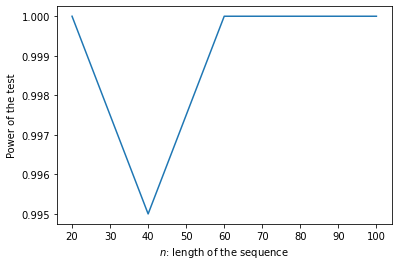

In [20]:
liste_n = [20*i for i in range(1,6)]
powers = []
for n in liste_n:
    CHAINS = build_chain(0, true_chain, n, numberchains=200)
    power = compute_power(H1, CHAINS, xmin, xmax, list_models, quantiles)
    powers.append(power)
plt.plot(liste_n,powers)
plt.ylabel('Power of the test')
plt.xlabel('$n$: length of the sequence')
plt.show()

#### Comparison with the KS test and the $\chi^2$ test

In [21]:
chi2power = chi2_test(CHAINS, CHAINSquantiles, H1, alpha, -3,3, K=100)
KSpower = KS_test(CHAINS, CHAINSquantiles, H1, alpha, mode='norm', params=(mu,sigma))
print('CHI2 POWER',chi2power)
print('KS POWER',KSpower)

CHI2 POWER 1.0
KS POWER 0.965


#### Visualization of the density of the invariant distribution of the chain and of an challenging alternative

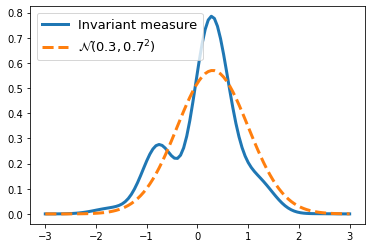

In [ ]:
CHAINS = build_chain(0, true_chain, 10000, numberchains=2)
x = np.linspace(-3,3,100)
y = list(map(true_density,x))
mu = 0.3
sigma = 0.7
def H1prop(x):
    return gaussian(x,mu,sigma)
normproposal = quad(H1prop, -3, 3)[0]
def H1(x):
    return H1prop(x)/normproposal
yb = list(map(H1,x))
plt.plot(x,y, label='Invariant measure', linewidth=3)
plt.plot(x,yb,label='$\mathcal{N}(0.3,0.7^2)$',linestyle='--',  linewidth=3)
plt.legend(fontsize=13)
plt.savefig('true_density_simu2.png',dpi=200)

# Example 3: ARCH

In [22]:
# INVARIANT DISTRIBUTION
theta = 0.8
def true_density(x):
    return 2 * (np.exp(-x**2/2) / np.sqrt(2*np.pi)) * sc.stats.norm.cdf(theta*x / ((1-theta**2)**(1/2)) )

def true_chain(prev_state):
        """ Markovian sampling on the sphere """
        z = np.random.normal(0,1)
        return (theta * np.abs(prev_state) + (1-theta**2)**(1/2) * z)

# ALTERNATIVE
mu = 1
sigma = 0.8
def H1(x):
    return (np.exp(-(x-mu)**2/(2*sigma**2)) / np.sqrt(2*np.pi*sigma**2))
def chain_H1(prev_state):
    return np.random.normal(mu,sigma**2)

# ESTIMATION OF THE QUANTILES
CHAINSproba = build_chain(0,chain_H1,100,numberchains=100)
CHAINSquantiles = build_chain(0,chain_H1,100,numberchains=100)
alpha = 0.05
grid_u = np.linspace(0,alpha,100)
list_models = [['hist',1,10]]
xmin = -10
xmax = 10
ualpha, quantiles = compute_ualpha(CHAINSproba, CHAINSquantiles, H1, xmin, xmax, grid_u, alpha, list_models)

#### Power of our test

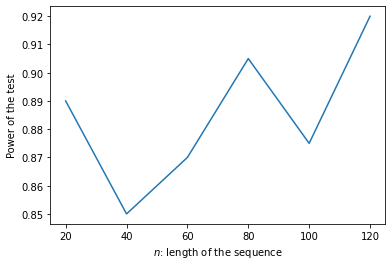

In [24]:
liste_n = [20*i for i in range(1,7)]
powers = []
for n in liste_n:
    CHAINS = build_chain(0,true_chain,n,numberchains=200)
    power = compute_power(H1, CHAINS, xmin, xmax, list_models, quantiles)
    powers.append(power)
plt.plot(liste_n,powers)
plt.ylabel('Power of the test')
plt.xlabel('$n$: length of the sequence')
plt.show()

#### Comparison with the KS test and the $\chi^2$ test

In [25]:
chi2power = chi2_test(CHAINS, CHAINSquantiles, H1, alpha, -20,20, K=100)
KSpower = KS_test(CHAINS, CHAINSquantiles, H1, alpha, mode='norm', params=(mu,sigma))
print('CHI2 POWER',chi2power)
print('KS POWER',KSpower)

CHI2 POWER 0.97
KS POWER 0.89


#### Visualization of the density of the invariant distribution of the chain and of an challenging alternative

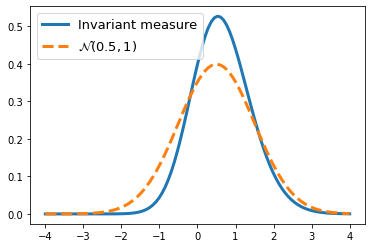

In [ ]:
CHAINS = build_chain(0, true_chain, 10000, numberchains=2)
x = np.linspace(-4,4,100)
y = list(map(true_density,x))
mu = 0.5
sigma = 1
def H1prop(x):
    return gaussian(x,mu,sigma)
def H1(x):
    return H1prop(x)/normproposal
yb = list(map(H1,x))
plt.plot(x,y, label='Invariant measure', linewidth=3)
plt.plot(x,yb,label='$\mathcal{N}(0.5,1)$',linestyle='--', linewidth=3)
plt.legend(fontsize=13)
plt.savefig('true_density_simu3.png',dpi=200)